In [1]:
import mysql.connector
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from decimal import Decimal
from matplotlib.ticker import AutoMinorLocator, FuncFormatter,MultipleLocator

In [10]:
import mysql.connector
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from decimal import Decimal
from matplotlib.ticker import AutoMinorLocator, FuncFormatter,MultipleLocator

# 1. Conectar ao banco de dados MySQL
con = mysql.connector.connect(
    host="localhost",        
    user="constructal_automate",     
    password="constructal_design_2024",    
    database="constructal_automate_results"
)

cur = con.cursor()

query_1a = f'''
SELECT 
    subquery.id,
    subquery.k,
    round(subquery.n_u * subquery.L / subquery.A, 2) AS sigma_u
FROM (
    SELECT 
        sp.id,
        sp.k,
        (p.b + sp.N_ts * sp.h_s) AS L, 
        (p.b * sp.t_1 + sp.N_ts * sp.h_s * sp.t_s) AS A,
        epb.n_u
    FROM constructal_automate_results.cbeb_elastoplasticbuckling AS epb
    INNER JOIN constructal_automate_results.cbeb_stiffenedplateanalysis AS spa 
        ON epb.stiffened_plate_analysis_id = spa.id
    INNER JOIN constructal_automate_results.csg_stiffenedplate AS sp 
        ON spa.stiffened_plate_id = sp.id
    INNER JOIN constructal_automate_results.csg_plate AS p 
        ON p.id = sp.plate_id
    WHERE spa.buckling_load_type_id = 1
) subquery;
'''
cur.execute(query_1a)
dados_flambagem_1a = cur.fetchall()

query_2a = f'''
SELECT sp.id, sp.k, epb.sigma_u FROM constructal_automate_results.cbeb_elastoplasticbuckling as epb
INNER JOIN constructal_automate_results.cbeb_stiffenedplateanalysis as spa on epb.stiffened_plate_analysis_id=spa.id
INNER JOIN constructal_automate_results.csg_stiffenedplate as sp on spa.stiffened_plate_id=sp.id 
WHERE 
spa.buckling_load_type_id = 2 and
epb.id not between 259 and 266;
'''
cur.execute(query_2a)
dados_flambagem_2a = cur.fetchall()

# Fechar a conexão com o banco de dados
con.close()

globals()['caso_ref_1a'] = dados_flambagem_1a[0]
globals()['caso_ref_2a'] = dados_flambagem_2a[0]

tensao_placa_ref_1a = dados_flambagem_1a[0][2]
tensao_placa_ref_2a = dados_flambagem_2a[0][2]
print('Tensão da Placa de Referência 1A: ', tensao_placa_ref_1a)
print('Tensão da Placa de Referência 2A: ', tensao_placa_ref_2a)

start_index = 1
end_index = 9

# Laço para criar as variáveis "caso_X_Y_2a"
for N_ls in range(2, 6):      # X varia de 2 a 5
    for N_ts in range(2, 6):  # Y varia de 2 a 5
        nome = f"caso_{N_ls}_{N_ts}"
        nome_1a = nome + '_1a'
        nome_2a = nome + '_2a'
        globals()[nome_1a] = dados_flambagem_1a[start_index:end_index]
        globals()[nome_2a] = dados_flambagem_2a[start_index:end_index]
        array_atual_1a = globals()[nome_1a]
        array_atual_2a = globals()[nome_2a]

        #array_atual = [(linha[0], linha[1], linha[2], round(linha[2]/tensao_placa_ref, 3)) for linha in array_atual]
        array_atual_1a = [(linha[0], linha[1], linha[2], (linha[2]/tensao_placa_ref_1a)) for linha in array_atual_1a]
        array_atual_2a = [(linha[0], linha[1], linha[2], (linha[2]/tensao_placa_ref_2a)) for linha in array_atual_2a]

        globals()[nome_1a] = array_atual_1a
        globals()[nome_2a] = array_atual_2a

        print('\n')
        print('------------------------------------------------------------')
        print('N_ls = ', N_ls, '; N_ts = ', N_ts)
        print('------------------------------------------------------------')
        print('----------------------UNIAXIAL------------------------------')
        print(array_atual_1a)
        print('----------------------BIAXIAL-------------------------------')
        print(array_atual_2a)
        
        start_index += 8
        end_index += 8

Tensão da Placa de Referência 1A:  186.46
Tensão da Placa de Referência 2A:  59.68


------------------------------------------------------------
N_ls =  2 ; N_ts =  2
------------------------------------------------------------
----------------------UNIAXIAL------------------------------
[(2, Decimal('56.200'), Decimal('31.03'), Decimal('0.1664163895741714040544888984')), (3, Decimal('14.100'), Decimal('352.90'), Decimal('1.892631127319532339375737424')), (4, Decimal('6.333'), Decimal('325.50'), Decimal('1.745682720154456719939933498')), (5, Decimal('3.550'), Decimal('312.62'), Decimal('1.676606242625764238978869463')), (6, Decimal('2.280'), Decimal('304.72'), Decimal('1.634237906253351925345918696')), (7, Decimal('1.600'), Decimal('299.08'), Decimal('1.603990131931781615359862705')), (8, Decimal('1.171'), Decimal('296.51'), Decimal('1.590207014909363938646358468')), (9, Decimal('0.900'), Decimal('291.80'), Decimal('1.564946905502520647860130859'))]
----------------------BIAXIAL------

In [17]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from decimal import Decimal
from matplotlib.ticker import AutoMinorLocator, FuncFormatter,MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
import locale
locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')

plt.rcParams['axes.formatter.use_locale'] = True
plt.rcParams['font.family'] = 'Lucida Sans'

min_k = 0
max_k = 60

min_sigma_u = 0
max_sigma_u = 6

k_data_ref = list(range(0, 61, 5))
sigma_u_2a_ns_data = [1 for _ in range(len(k_data_ref))]

def generate_constructal_design_plots(N_ls, N_ts, k_data, nus_1a_data, nus_2a_data):   
    fig, ax = plt.subplots(figsize=(8, 6))

    formatter = ticker.FuncFormatter(lambda x, _: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.plot(k_data, nus_1a_data, '-o', color='#2b5a74', lw=2, markersize=4, label=rf'$NUS_{{1A}}\;(N_{{ls}} = {N_ls}, N_{{ts}} = {N_ts})$')
    ax.plot(k_data, nus_2a_data, '-o', color='#d84528', lw=2, markersize=4, label=rf'$NUS_{{2A}}\;(N_{{ls}} = {N_ls}, N_{{ts}} = {N_ts})$')
    
    
    ax.set_xlabel(rf'$h_{{s}}/t_{{s}}$', fontsize=18)
    # ax.set_ylabel(rf'$Tensão\;Última\;de\;Flambagem\;Normalizada$', fontsize=18)
    ax.set_ylabel(rf'$NUS$', fontsize=18)
    ax.legend(loc='upper right', fontsize=14)
    
    ax.grid(True, which='major', linestyle='-', linewidth=0.25, color='gray')  # Grade principal
    ax.grid(True, which='minor', linestyle='--', linewidth=0.25, color='lightgray')  # Grade secundária
    
    ax.set_xlim([min_k, max_k])
    ax.set_ylim([min_sigma_u, max_sigma_u])
    
    # Configurar os locators de forma explícita
    ax.xaxis.set_major_locator(MultipleLocator(10))  # Ticks principais no eixo X
    ax.xaxis.set_minor_locator(MultipleLocator(2))   # Ticks menores no eixo X
    
    ax.yaxis.set_major_locator(MultipleLocator(1))   # Ticks principais no eixo Y
    ax.yaxis.set_minor_locator(MultipleLocator(0.2)) # Ticks menores no eixo Y
    ax.tick_params(axis='both', labelsize=18)
    
    # plt.savefig(f'graficos_design_construtal/grafico-L{N_ls}-T{N_ts}-phi-0.3.png')
    plt.savefig(f'graficos_estudo_comparativo/nus/grafico_L{N_ls}_T{N_ts}_phi_0.3.png')
    
    # Exibir o gráfico
    # plt.show()

N_ls = 2 , N_ts = 2


------------------------------------------------------------
N_ls =  2 ; N_ts =  2
------------------------------------------------------------
k_data =  (Decimal('56.200'), Decimal('14.100'), Decimal('6.333'), Decimal('3.550'), Decimal('2.280'), Decimal('1.600'), Decimal('1.171'), Decimal('0.900'))
------------------------------------------------------------
nus_1a_data =  (Decimal('0.1664163895741714040544888984'), Decimal('1.892631127319532339375737424'), Decimal('1.745682720154456719939933498'), Decimal('1.676606242625764238978869463'), Decimal('1.634237906253351925345918696'), Decimal('1.603990131931781615359862705'), Decimal('1.590207014909363938646358468'), Decimal('1.564946905502520647860130859'))
------------------------------------------------------------
nus_2a_data =  (Decimal('0.4284517426273458445040214477'), Decimal('3.287198391420911528150134048'), Decimal('3.543063002680965147453083110'), Decimal('3.670911528150134048257372654'), Decimal('3.709617

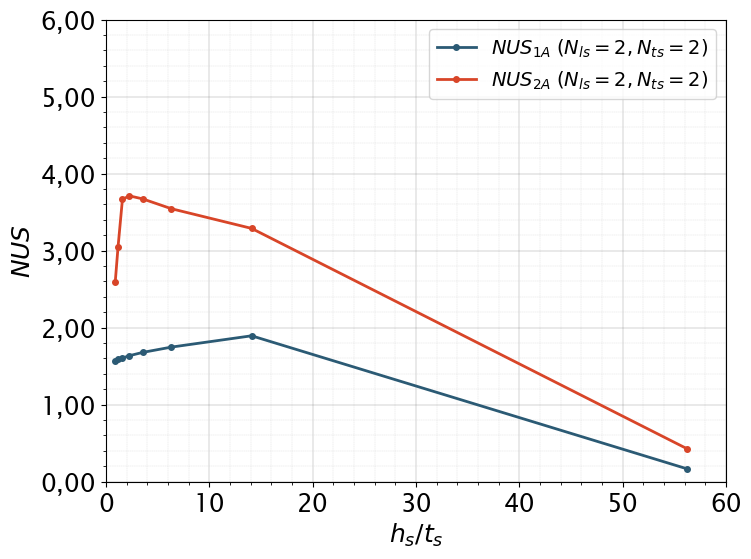

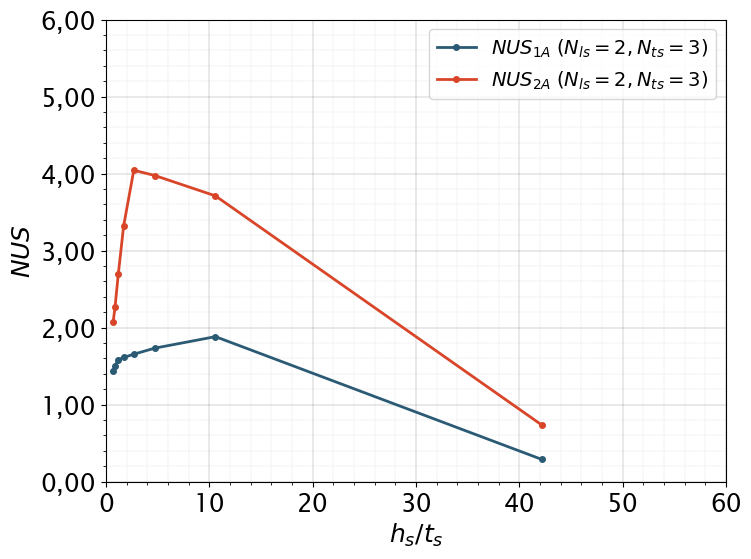

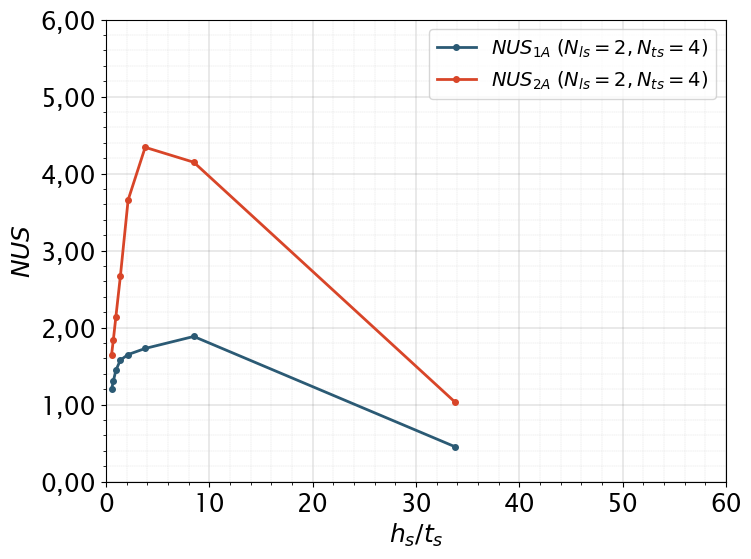

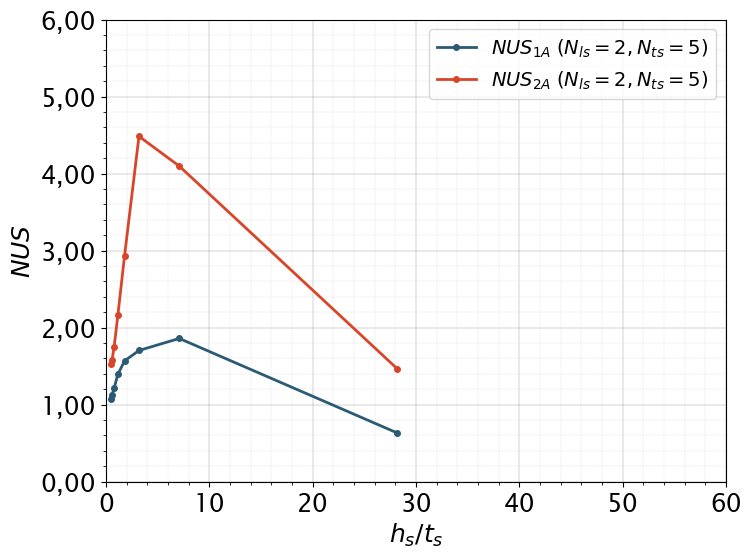

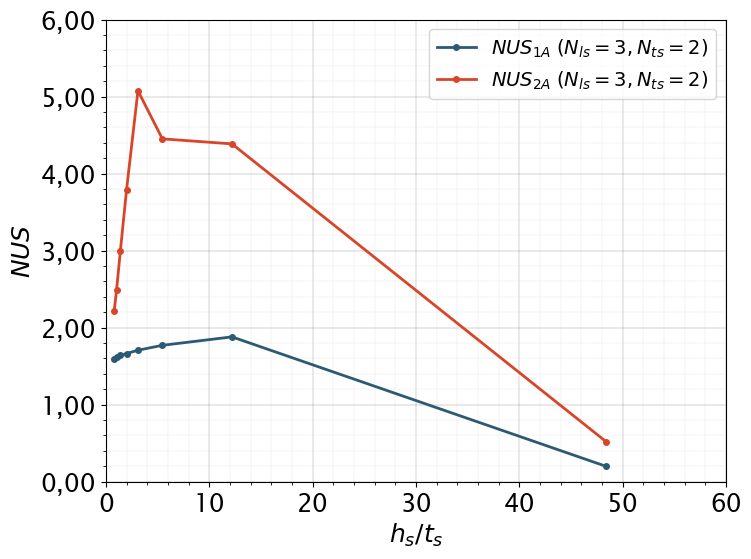

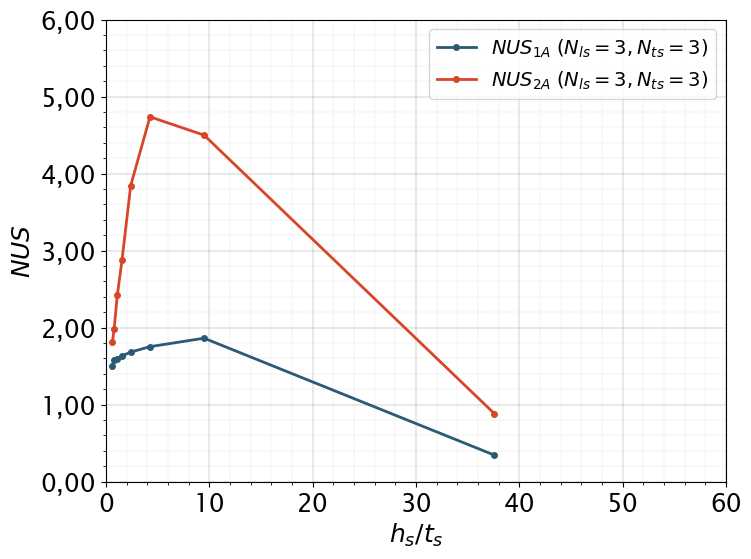

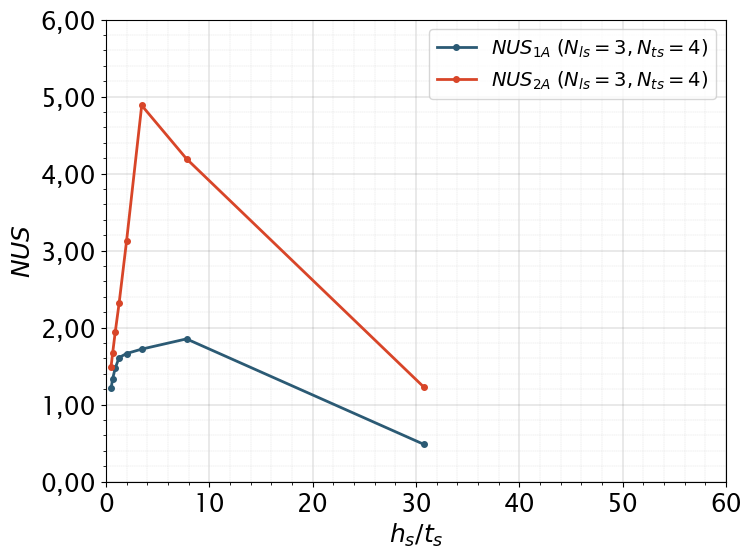

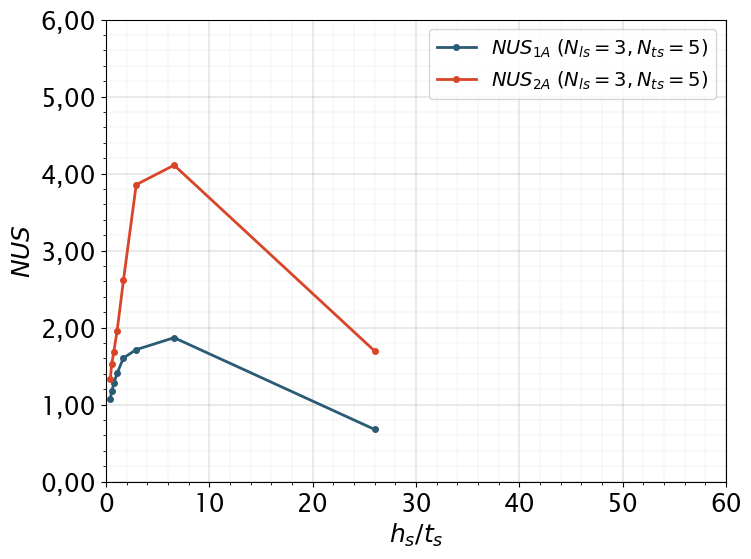

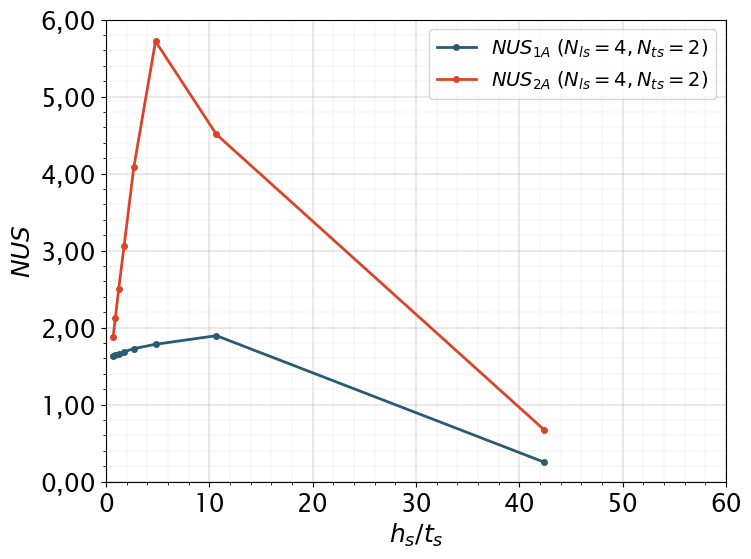

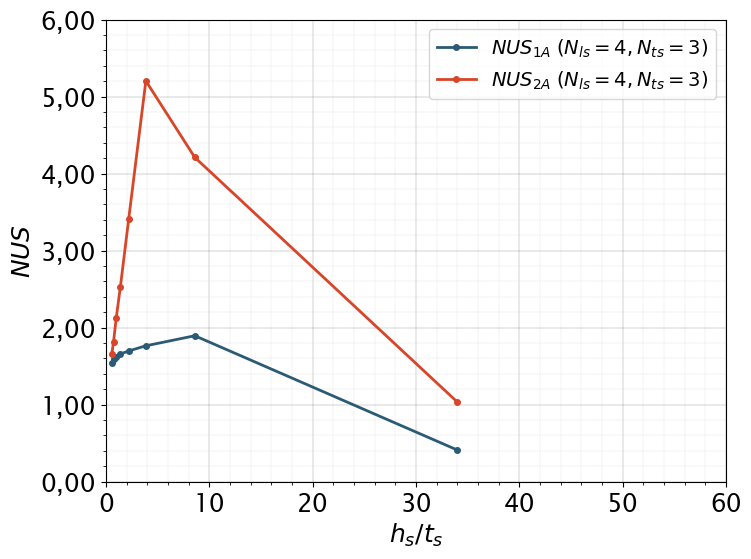

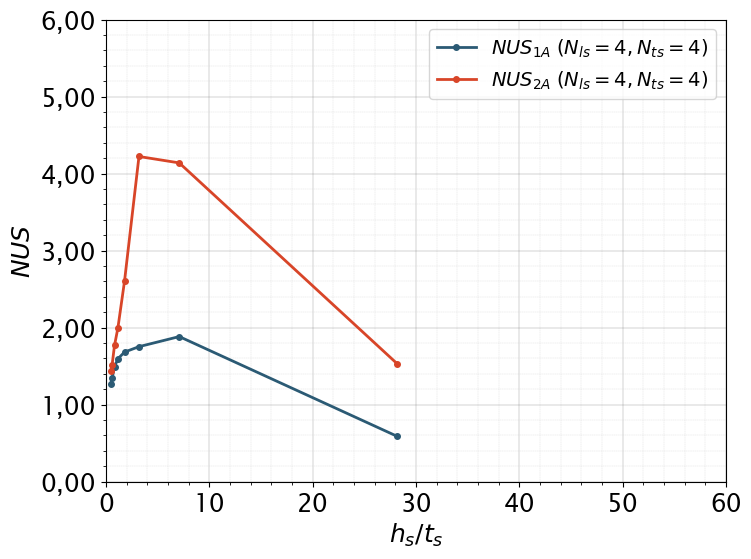

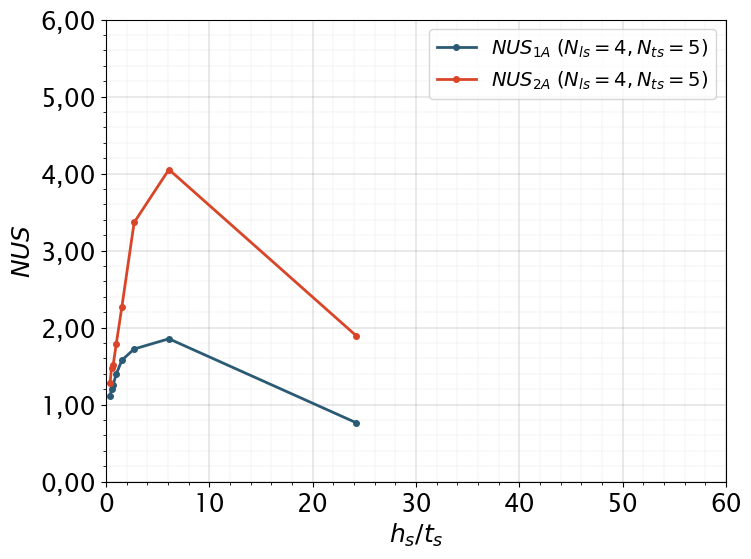

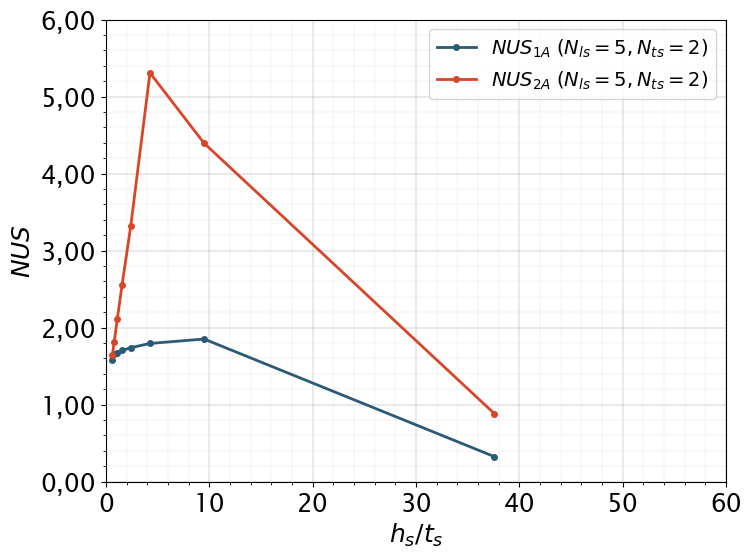

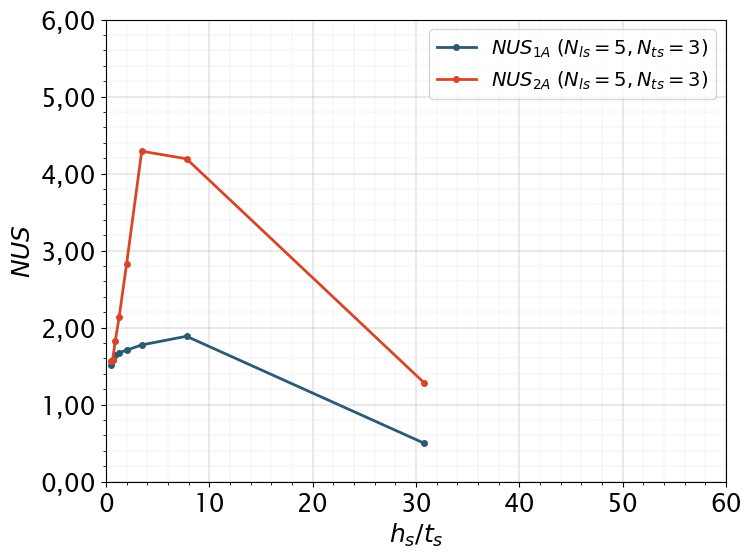

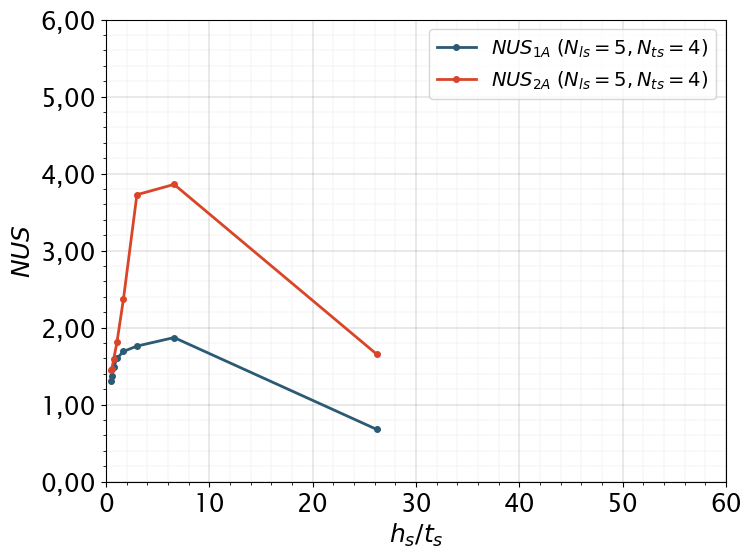

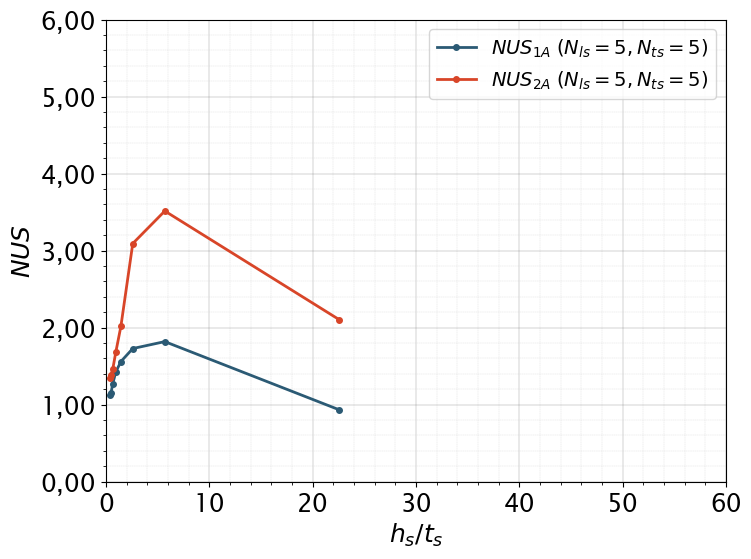

In [18]:
'''
[0] sp.id
[1] sp.k
[2] epb.sigma_u
'''

for N_ls in range(2, 6):
    for N_ts in range(2, 6):
        nome = f"caso_{N_ls}_{N_ts}"
        nome_1a = nome + '_1a'
        nome_2a = nome + '_2a'
        k_data, nus_1a_data = zip(*[(obj[1], obj[3]) for obj in globals()[nome_1a]])
        k_data, nus_2a_data = zip(*[(obj[1], obj[3]) for obj in globals()[nome_2a]])        
        print(f'N_ls = {N_ls} , N_ts = {N_ts}')

        print('\n')
        print('------------------------------------------------------------')
        print('N_ls = ', N_ls, '; N_ts = ', N_ts)
        print('------------------------------------------------------------')
        print('k_data = ', k_data)
        print('------------------------------------------------------------')
        print('nus_1a_data = ', nus_1a_data)
        print('------------------------------------------------------------')
        print('nus_2a_data = ', nus_2a_data)
        print('------------------------------------------------------------')
        generate_constructal_design_plots(N_ls, N_ts, k_data, nus_1a_data, nus_2a_data)